# MRI - Visualization & Segmentation of brain images

In this practical session ...

Dowload the data from the virtual campus and store it in your computer. Then, upload the data into the Colab session using the left menu.

Remember to create a **copy** of this file in your drive and rename it to be able to edit.

NOTES:

-   If you need to review some Python basics, you can use [this tutorial](https://colab.research.google.com/drive/1lrI9l-zQf28swxkJ9dI1iBTNMlVVXqCj?usp=sharing).
-   If you want to learn more about [nilearn](https://https://nilearn.github.io/stable/index.html#) and [nibabel](https://nipy.org/nibabel/), check the online documentation.


In [1]:
# Check and install the toolboxes
try:
    import nibabel
except ImportError:
    # if not, install it using pip
    !pip install nibabel

# And nilearn
try:
    import nilearn
except ImportError:
    # if not, install it using pip
    !pip install nilearn

# And nilearn
try:
    import nipype
except ImportError:
    # if not, install it using pip
    !pip install nipype

## 1. Interacting with images

We will see some tools for visualization of MR images (here, brain scans)


In [2]:
import nibabel as nib
import nilearn
from nilearn import plotting
import numpy as np
import matplotlib.pyplot as plt

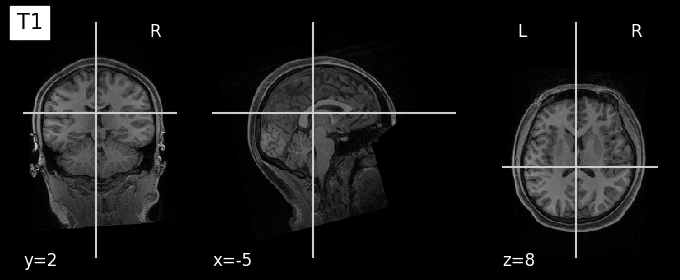

In [3]:
T1_filename = "data/example_T1w.nii.gz"
T1_img = nib.load(T1_filename)

# need to grab data arrays
T1_data = T1_img.get_fdata()

# plot
plotting.plot_anat(T1_filename, title="T1", vmax=500)


**Exercise:** Write a code to visualize the T2 scan. Descibe the differences that you observe between the two types of images.


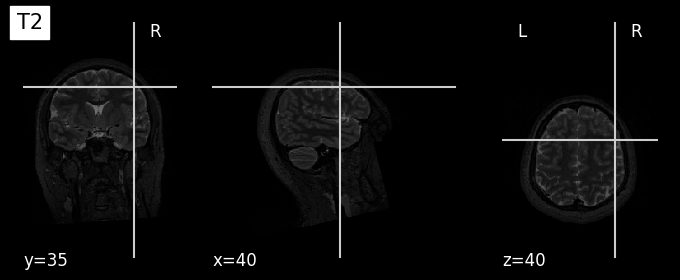

In [4]:
T2_img = nib.load("data/example_T2w.nii.gz")
T2_data = T2_img.get_fdata()

coords = (40, 35, 40)
plotting.plot_anat(T2_img, title="T2", vmax=500, cut_coords=coords)


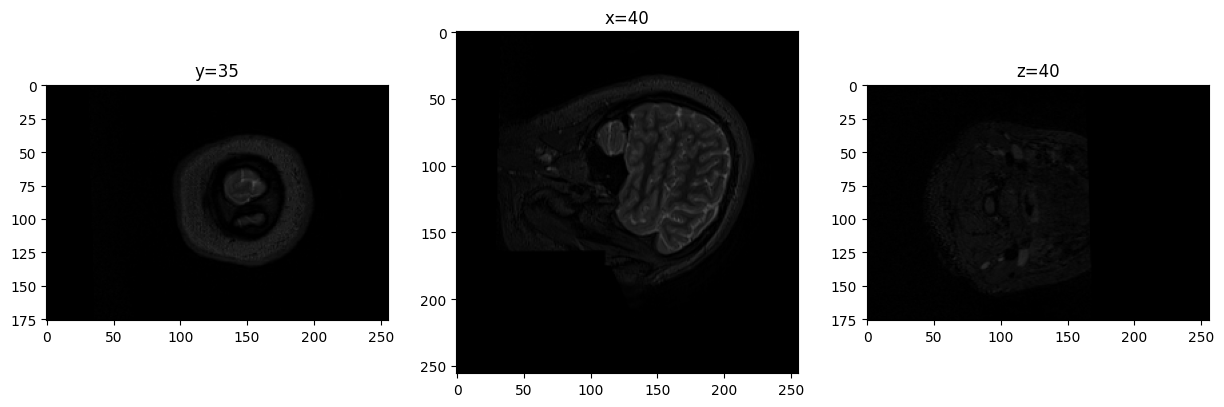

In [5]:

# I wanna try something: Can I take the slices myself?

slice_x = T2_data[40, :, :]
slice_y = T2_data[:, 35, :]
slice_z = T2_data[:, :, 40]

# Let's plot them
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(slice_y, cmap="gray", vmax=500)
ax[0].set_title("y=35")
ax[1].imshow(slice_x, cmap="gray", vmax=500)
ax[1].set_title("x=40")
ax[2].imshow(slice_z, cmap="gray", vmax=500)
ax[2].set_title("z=40")

plt.show()

## 2. Artifact correction and clean-up

-   Correcting artifacts and cleaning the image is crucial for the success of **automated processing methods** (i.e., segmentation, registration, ...)
-   A typical issue with MRI scans is caused by **spatial inhomogeneties** of the magnetic field, namely **bias field**, a smooth signal intensity variation within tissue of the same physical properties.
-   Note that **\*bias field** is modeled as a multiplicative factor, whereas **_noise_** is assumed to be an additive and spatially independent (Gaussian) factor.


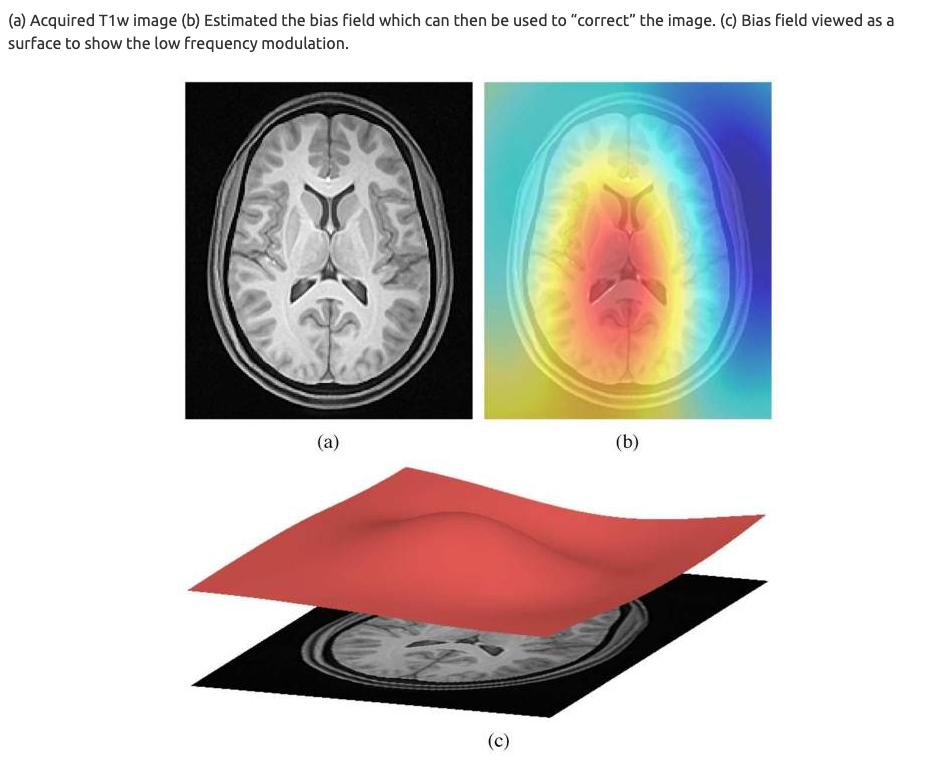


### Bias field correction

There are many automated pipelines that can be used to perform this corrections (some are integrated within longer pipelines such as FreeSurfer, FSL and SPM).

In this example, we will use the ANTs software. It can be run independently (see [documentation](https://http://stnava.github.io/ANTs/)) or within the nipype package.


In [6]:
from nipype.interfaces.ants import N4BiasFieldCorrection

n4 = N4BiasFieldCorrection()
n4.inputs.dimension = 3
n4.inputs.input_image = "example_T1w.nii.gz"
n4.inputs.bspline_fitting_distance = 300
n4.inputs.shrink_factor = 3
n4.inputs.n_iterations = [50, 50, 30, 20]
n4.cmdline


'N4BiasFieldCorrection --bspline-fitting [ 300 ] -d 3 --input-image example_T1w.nii.gz --convergence [ 50x50x30x20 ] --output example_T1w_corrected.nii.gz --shrink-factor 3'

The above code would give an instruction that should be run from command line.

**DO NOT RUN THIS NOW!!** Note that you have all the images that you need in your images folder.


The **_bias field correction_** produces changes in the histogram and can have a strong impact on a subsequant segmentation task.


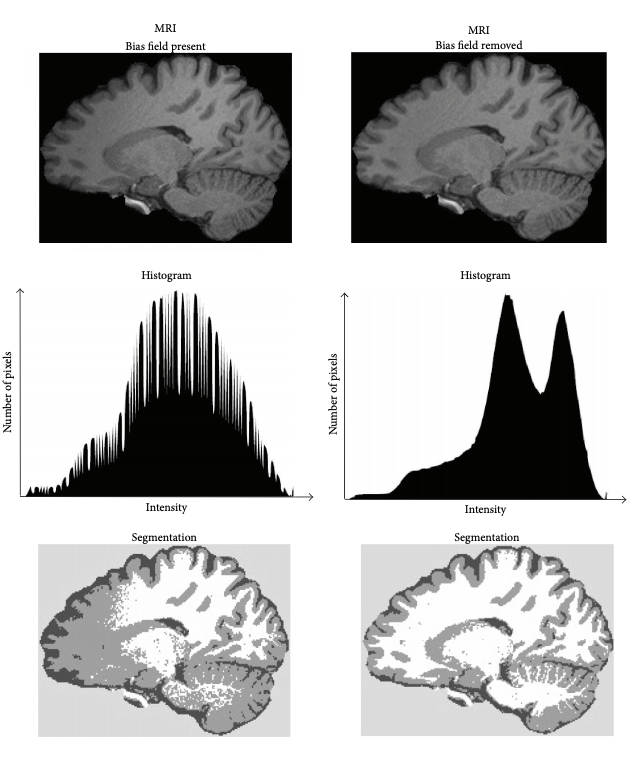


### Visualizing images before and after correction

We'll use nibabel/nilearn tools to visualize some of the example images.


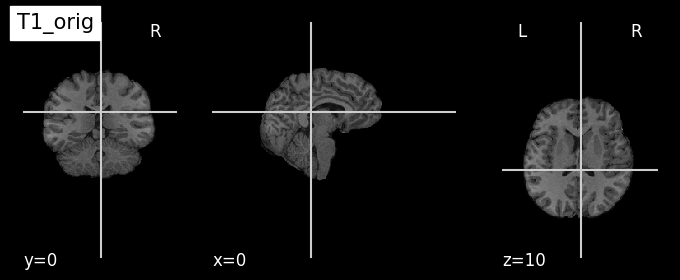

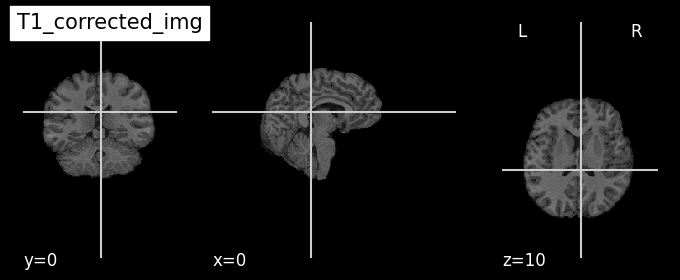

In [7]:
import nibabel as nib
from nilearn import plotting

T1_orig = "data/example_T1_brain.nii.gz"
T1_corrected = "data/example_T1_brain_restore.nii.gz"
# T1_img_orig = nib.load(T1_orig)
# T1_img_corrected = nib.load(T1_corrected)

# plot
cut_coords = (0, 0, 10)  # try changing these coordinates
plotting.plot_anat(T1_orig, title="T1_orig", cut_coords=cut_coords, vmax=500)
plotting.plot_anat(T1_corrected, title="T1_corrected_img", cut_coords=cut_coords, vmax=500)

**Exercise:** Plot the bias field image (also available in your folder)


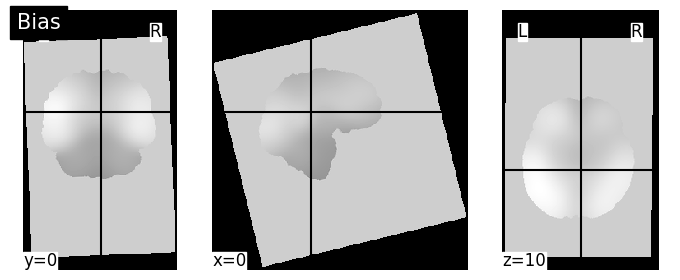

In [8]:
bias_img = nib.load("data/example_T1_brain_bias.nii.gz")
plotting.plot_anat(bias_img, title="Bias", cut_coords=cut_coords)

## 3. Brain extraction

A common preprocessing step in brain MRI is to extract the brain (separate the brain from skull, skin, neck,...).

Note that, brain extraction has also been run somewhere else, and you can check the outputs in the folders.


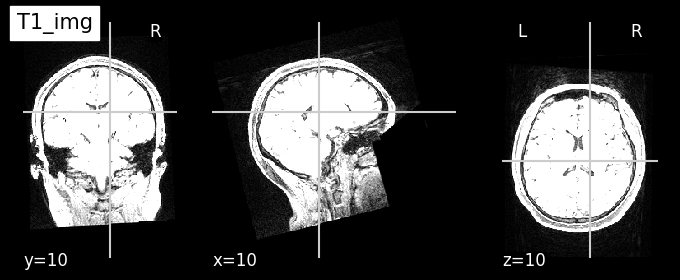

In [15]:
from nipype.interfaces.ants.segmentation import BrainExtraction

T1_img = "data/example_T1w.nii.gz"
T1_img = nib.load(T1_img)

# plot
cut_coords = (10, 10, 10)
plotting.plot_anat(T1_img, title="T1_img", cut_coords=cut_coords, vmax=255)

**Exercise:** Plot the image after brain extraction.

-   Based on the previous images, which are the methodological basis of the brain extraction tools?
-   Which is the utility of the 'cut_coords' and 'vmax' parameters?


c:\Users\mirxm\OneDrive\Escritorio\Storage\Estudis\UB\8e Semestre\Física Mèdica\Medical-Imaging\.venv\Lib\site-packages\nilearn\image\resampling.py:597: UserWarning: Casting data from int32 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")


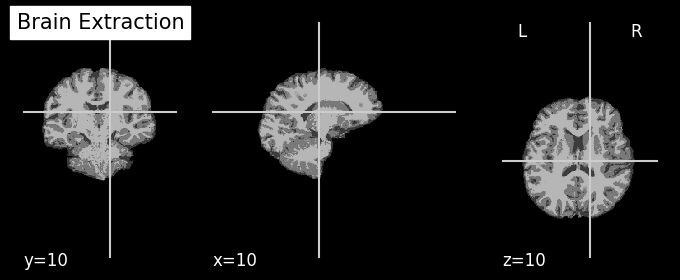

In [16]:
# There exist several techniques used to segment MRIs to extract the brain, some of the most comonly used being:
#   1. Threshold-based methods:
#           By looking into the histogram of the MRI, one can find a threshold that segments the brain from the background. A simple algorithm could go as follows:
#           One can find a threshold for the histogram that creates a mask that separates the body from the background. By applying various erosion and dilation
#           operations, one can separate the whole mask into different "blobs", corresponding to the brain and the rest of the skull. This is analogous to "finding 
#           black (low intensity) surface in the images which represents the cerebrospinal fluid (CSF), which could be used as the outer boundary of the brain.
#   2. Edge-based methods:
#           By applyin various edge detection filters (such as the ones studied in the previous lab), one can find the edges of the brain and use them to extract
#           the brain from the background.
#   3. Clustering-based methods:
#           One can use a clustering method, which groups pixels into clusters based on their intensity values. The clusters can then be used to segment the brain.
#   4. Atlas-based methods:
#           One can use a pre-segmented atlas of the brain to segment the brain from the MRI, by mapping the extracted image to a known atlas.
# Finally, there are also some more advanced methods that are used to segment the brain such as:
#   6. Deep learning methods:
#           This method uses artificial neural networks to learn how to segment the brain from a large dataset of labeled images


# To answer the second question, in the previous example, cut_coords is used to specify the coordinates of the slice that is to be plotted. For example, 
# if we set cut_coords=(0, 10, 20), we will be shown three images, corresponding to the slices defined as x=0, y=10 and z=20.
# vmax, instead, is used to specify the maximum value of the intensity of the image. This has to be selected carefully, as having a too high value will
# result in the image being too dim, while having it too low will result on the image saturating, and thus losing information. This is equivalent to 
# equalizing the histogram with a very low or very high value for the maximum intensity.

# Here's the already extracted image of the brain:
brain_seg = nib.load("data/example_T1_brain_seg.nii.gz")
plotting.plot_anat(brain_seg, title="Brain Extraction", cut_coords=cut_coords)

## 4. Brain Segmentation


Brain segmentation is a common preprocessing step that separates the main brain tissues (White Matter, Gray Matter and CSF) using the histogram. This is typically done with T1-weighted images.


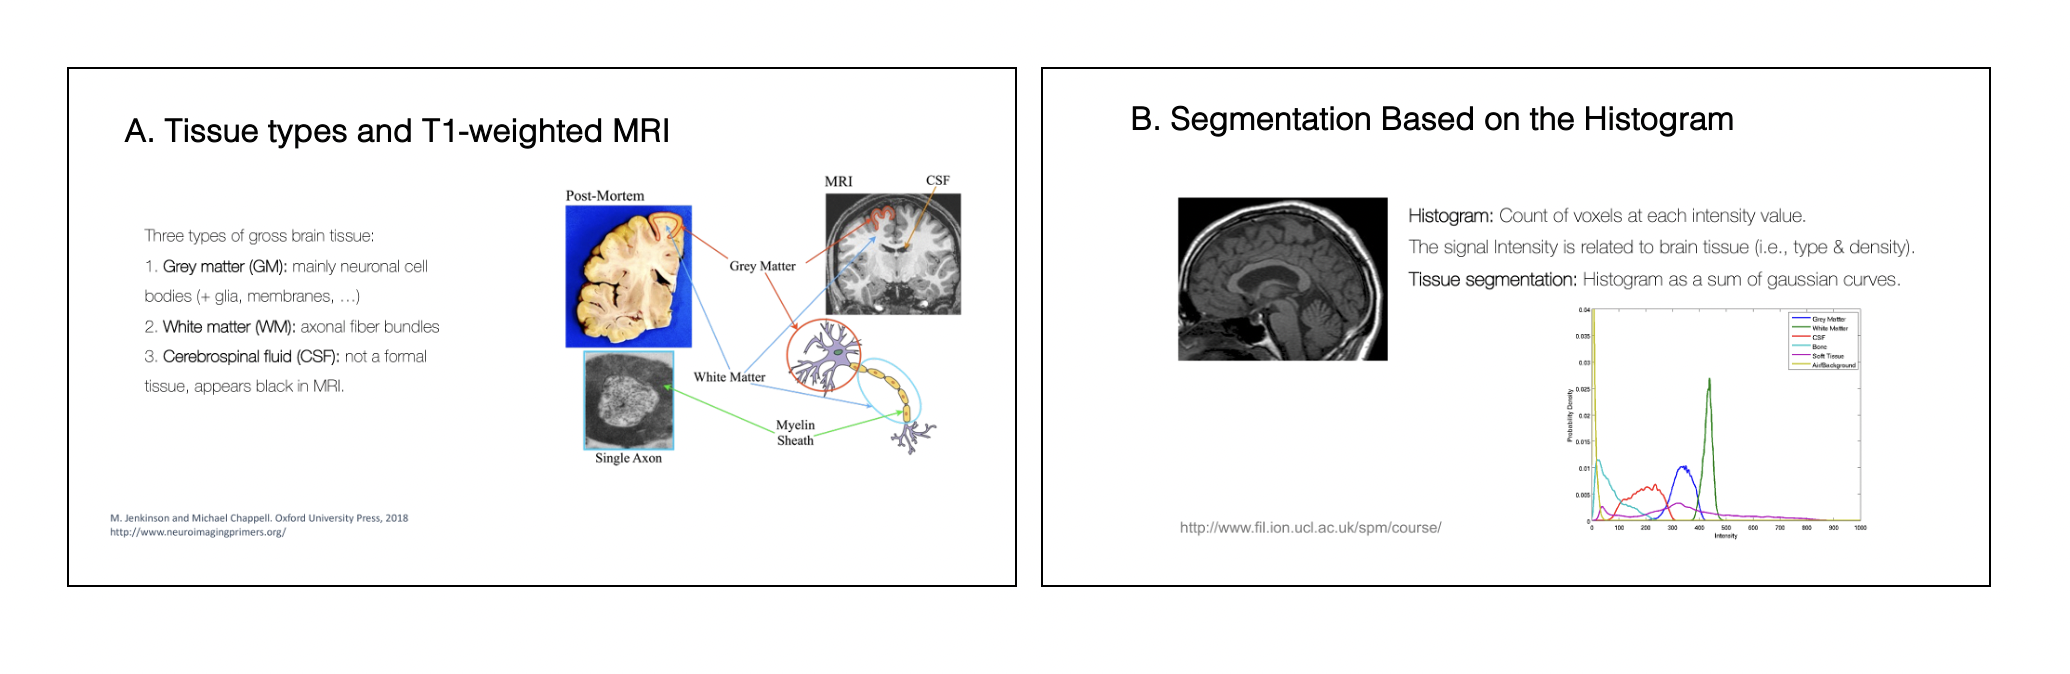


Here, we will explore the main outputs of brain segmentation.


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


Text(0.5, 1.0, 'T1 data before skull-stripping')

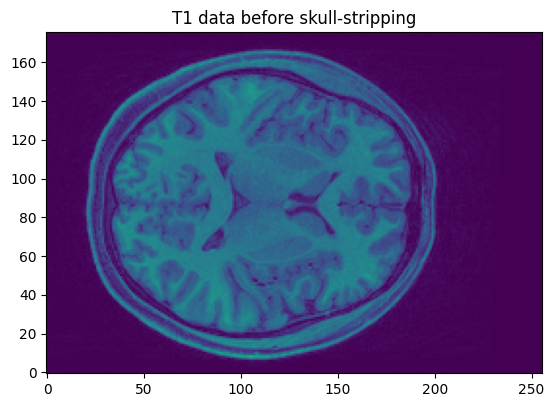

In [20]:
# use imshow to plot the figures
# Plot first figure
T1_img = "data/example_T1w.nii.gz"
T1_img = nib.load(T1_img)
T1_data = T1_img.get_fdata()
plt.imshow(T1_data[:, :, 160], vmax=500, origin="lower")
plt.title("T1 data before skull-stripping")


Now, we can compute the histogram of this image:


(0.0, 255.0)

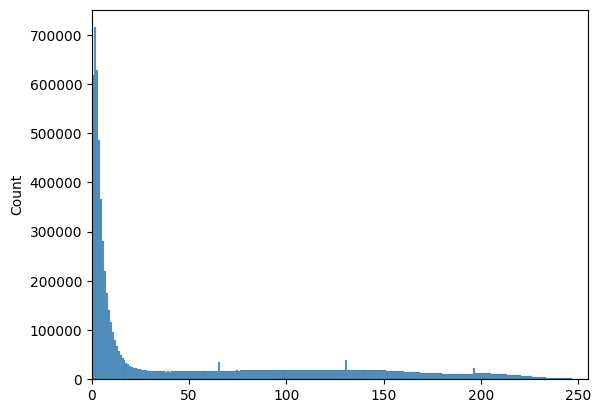

In [21]:
import numpy as np

# Compute the optimal bin size according to the data
bins = np.histogram_bin_edges(T1_data[T1_data != 0], bins="auto")
# Plot the histogram
sns.histplot(T1_data[T1_data != 0], bins=bins)
plt.xlim([0, 255])

**Question:** What do you observe from the previous histogram?


In [ ]:
# Things TODO

**Exercise:** plot the image and the histogram after skull stripping. Try also examining other slices and sections.


In [ ]:
# place your code here (plot image after skull stripping and store data into 'T1_brain_data')


In [ ]:
# place your code here (histogram)


Now, we will examine the outputs of the segmentation together with the abobe histogram:


In [23]:
# NOTE: consider that brain data is stored into 'T1_brain_data'

import itertools

T1_seg_image = nib.load("data/example_T1_brain_seg.nii.gz")
T1_seg_data = T1_seg_image.get_fdata()
labels = np.unique(T1_seg_data[T1_seg_data != 0]).astype("int")
palette = itertools.cycle(sns.color_palette("Set3"))
for label in labels:
    sns.histplot(T1_brain_data[T1_seg_data == label], bins=bins, color=next(palette), alpha=0.6)

NameError: name 'T1_brain_data' is not defined

**Exercise**: Use the histogram above to explore the differences of performing segmentation on images before/after bias correction.


In [ ]:
# place your code here


Final remarks: A question of probability:


In [ ]:
GMprob_image = "example_T1_brain_pve_1.nii.gz"
GMprob_image = nib.load(GMprob_image)
GM_probmap = GMprob_image.get_fdata()

plotting.plot_roi(roi_img=GMprob_image, bg_img=T1_img, alpha=0.2, cmap="jet", vmin=0.5, vmax=1)


**Exercise**: Try different options of the plotting.plot_roi function to improve the image above.


In [ ]:
# place your code here
